# Application of Fuzzy logic and Genetic Algorithm in Stock Trading

This notebook explores the application of genetic algorithms in optimizing the fuzzy rules as applied in technical analysis of stocks.

In [1]:
# import libraries
import os
import pickle
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import matplotlib.pyplot as plt
import copy
from Gene import Gene
from Genome import Genome
from Population import Population
from Crossover import single_point, two_point, uniform, linear, SBX, crossover
from Fitness import evaluate_fitness
from Selection import roulette_wheel, RWS, SUS, tournament, rank
import random
from Base_genome import base_genome
from Seed_genome import seed_genome
from helper_module import split_train_test_sets, split_train_set
import Evolution

                Close       Open       High        Low   Volume
Date                                                           
1986-01-02   172.6575   172.6575   172.6575   172.6575    600.0
1986-01-03   172.6575   172.6575   172.6575   172.6575   1900.0
1986-01-06   175.4879   175.4879   175.4879   175.4879   2800.0
1986-01-07   181.1488   175.4879   181.1488   175.4879   3200.0
1986-01-09   181.1488   181.1488   181.1488   181.1488   2600.0
...               ...        ...        ...        ...      ...
2023-09-12  1781.0000  1786.0000  1809.0000  1781.0000  12985.0
2023-09-13  1787.0000  1799.0000  1799.0000  1781.0000  16850.0
2023-09-14  1795.0000  1795.0000  1795.0000  1782.0000  12070.0
2023-09-15  1752.0000  1795.0000  1810.0000  1752.0000  29105.0
2023-09-18  1752.0000  1789.0000  1789.0000  1752.0000  27225.0

[8861 rows x 5 columns]


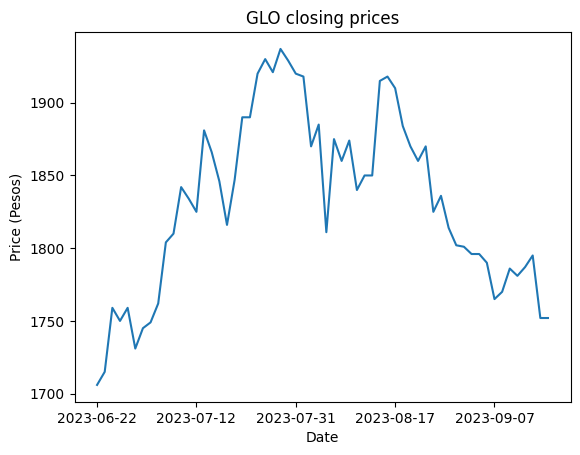

In [2]:
# read and print sample historical stock price data
series = pd.read_csv('../../Data/PH-historical-stock-price-data-csv/GLO.csv', header = 0, index_col = 'Date')
print(series)

# plot historical stock price data
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(series['Close'].tail(60))
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

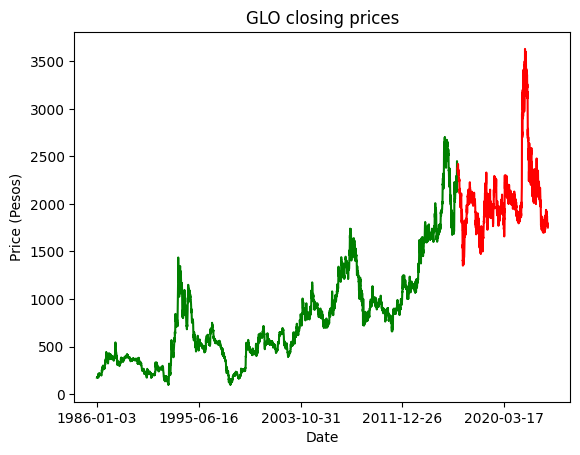

In [3]:
# split data into train and test sets
train, test = split_train_test_sets(series)

# plot the train and test sets
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(train['Close'], 'g')
ax.plot(test['Close'], 'r')
ax.set_xticks(ax.get_xticks()[::2000])
plt.show()

In [4]:
# def split_train_set(series:pd.DataFrame, window:int = 500) -> list[pd.DataFrame]:
#     """
#     This function splits or slices the train set into batches with a corresponding window length

#     Arguments:
#         series:pd.DataFrame
#             a pandas dataframe containing the training set of the 

#     Returns:
#         train_set:list[pd.DataFrame]
#             a list containing multiple pandas dataframes
#     """
#     train_set = list()
#     for i in range(len(series)-window):
#         train_set.append(copy.deepcopy(series[i:i+window]))
#     return train_set

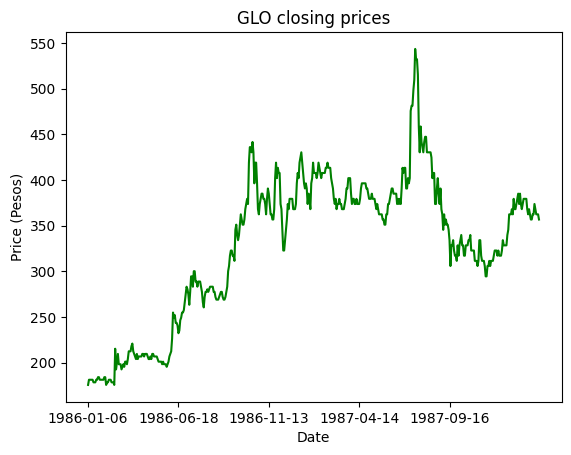

In [5]:
# split the train set into multiple batches
train_set = split_train_set(train)

# plot a sample of the train set
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(train_set[1]['Close'], 'g')
ax.set_xticks(ax.get_xticks()[::100])
plt.show()

In [6]:
# create the base and seed genomes
BASE_GENOME = base_genome()
SEED_GENOME = seed_genome()

In [7]:
# genome1 = Genome(SEED_GENOME)
genome1 = Genome(BASE_GENOME)
genome1.initialize_genome()
# stock, num_trades, bnh_returns, strat_returns, strat_sharpe_ratio, strat_sortino_ratio, max_drawdown= evaluate_fitness(train_set[2500], genome1)
fitness = evaluate_fitness(train_set[2500], genome1)
# print(returns)
# print(num_trades)
# print(bnh_returns)
# print(strat_returns)
# print(strat_sharpe_ratio)
print(fitness)
# print(max_drawdown)

-inf


In [8]:
genome1 = Genome(SEED_GENOME)
genome2 = Genome(BASE_GENOME)
population1 = Population()
population1.seed_population(seed_genome = genome1, num_seeds = 1)
population1.add_and_initialize_to_population(num_genomes = 2, base_genome = genome2)
print(population1)
    

Population 0 has 3 genome/s
It has the following gene/s:
GENE_ID: 4
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30

GENE_ID: 6
Gene name: RSI_window
Value: 126

Gene name: RSI_p1
Value: -0.07133557893393361

Gene name: RSI_p2
Value: 0.16857427847557438

Gene name: RSI_p3
Value: -0.2666676035924165

Gene name: RSI_p4
Value: 0.9203016748484194

Gene name: RSI_low_membership
Value: [53, 60]

Gene name: RSI_middle_membership
Value: [0, 22, 60]

Gene name: RSI_high_membership
Value: [21, 97]

Gene name: entry_condition
Value: [75, 76]

Gene name: stop_loss
Value: 0.03276043882859834

Gene name: z_rolling_window
Value: 274

GENE_ID: 8


In [9]:
genome1 = Genome(SEED_GENOME)
genome2 = Genome(BASE_GENOME)
genome2.initialize_genome()

offspring1, offspring2 = SBX(genome1, genome2)
print(offspring1)
# print(offspring2)


GENE_ID: 12
Gene name: RSI_window
Value: 12

Gene name: RSI_p1
Value: 0.8015654624079834

Gene name: RSI_p2
Value: 0.9086721010707057

Gene name: RSI_p3
Value: 0.6466376774959096

Gene name: RSI_p4
Value: 0.6537761963528896

Gene name: RSI_low_membership
Value: [6.108811672798882, 27.84130775479018]

Gene name: RSI_middle_membership
Value: [26.153073375358787, 53.68983480114812, 71.7713945489954]

Gene name: RSI_high_membership
Value: [75, 93]

Gene name: entry_condition
Value: [50.01845754449201, 50.028345514755586]

Gene name: stop_loss
Value: 0.9352705181455658

Gene name: z_rolling_window
Value: 29




In [10]:
# class Evolution():
#     """
#     This class provides details on the evolution class
#     """
    
#     def __init__(self, population:Population):
#         """
#         This function initializes the evolution class
#         """
#         self.population = population
    
#     def run(self, fitness:callable, generations:int = 100, checkpoint_interval:int = 10):
#         """
#         This function simulates evolution through the population
        
#         Arguments:            
#             generations: int
#                 the number of generations the evolution should run
                
#             checkpoint_interval: int
#                 the interval for saving a checkpoint in the evolution of the genomes
                
#         Returns:
#             None
#         """
#         for _ in range(generations):
#             pass
    
#     def checkpoint():
#         """
#         Some text
#         """
#         pass
                

In [11]:
# evaluate_fitness_partial = partial(evaluate_fitness, series = train_set[2500])
genome1 = Genome(SEED_GENOME)
genome2 = Genome(BASE_GENOME)
population1 = Population()
population1.seed_population(seed_genome = genome1, num_seeds = 25)
population1.add_and_initialize_to_population(base_genome = genome2, num_genomes = 75)
# new_population = roulette_wheel(population = population1, fitness_func = evaluate_fitness, series = train_set[random.randint(1, len(train_set))])
# new_population = RWS(population = population1, fitness_func = evaluate_fitness, series = train_set[random.randint(1, len(train_set))])
# new_population = SUS(population = population1, fitness_func = evaluate_fitness, series = train_set[random.randint(1, len(train_set))])
# new_population = tournament(population = population1, fitness_func = evaluate_fitness, series = train_set[random.randint(1, len(train_set))])
new_population = rank(population = population1, fitness_func = evaluate_fitness, series = train_set[random.randint(1, len(train_set))])
# roulette_wheel(population = population1, fitness_func = evaluate_fitness_partial, series = train_set[2500])
print(new_population)

Population 2 has 50 genome/s
It has the following gene/s:
GENE_ID: 36
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30

GENE_ID: 24
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30

GENE_ID: 38
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value

In [12]:
print(type(new_population))

<class 'Population.Population'>


In [13]:
new_population = crossover(population=new_population)
print(new_population)

Population 3 has 100 genome/s
It has the following gene/s:
GENE_ID: 36
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30

GENE_ID: 24
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30

GENE_ID: 38
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Valu

In [14]:
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
with open('./checkpoints/checkpoints.pkl', 'wb') as output:
    pickle.dump(new_population, output, pickle.HIGHEST_PROTOCOL)

with open('./checkpoints/checkpoints.pkl', 'rb') as input:
    test_population = pickle.load(input)
    
print(test_population)

Population 3 has 100 genome/s
It has the following gene/s:
GENE_ID: 36
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30

GENE_ID: 24
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30

GENE_ID: 38
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Valu

In [22]:
population = Evolution.run(seed_genome = genome1,
                           base_genome = genome2, 
                           train_set = train_set,
                           fitness_func = evaluate_fitness)

Population 27 has 100 genome/s
It has the following gene/s:
GENE_ID: 1617
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30

GENE_ID: 1629
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30

GENE_ID: 1627
Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_

ValueError: window must be an integer 0 or greater

In [ ]:
print(type(test_population))

In [ ]:
genome1 = Genome(SEED_GENOME)

for gene in genome1.genome:
    gene.mutate()

print(genome1)

In [ ]:
def run_evolution(population = None, generations:int = None, checkpoint_interval:int = None) -> None:
    """
    This function simulates evolution through the population
    of genes
    
    Arguments:
        population: population class
            a class of population
        
        generations: int
            the number of generations the evolution should run
            
        checkpoints: int
            the interval for saving a checkpoint in the evolution of the genomes
            
    Returns:
        None
        
    """
    pass

    # TODO: include checkpoints here




In [ ]:
def main() -> None:
    """
    This function runs all the other functions as provided in the above
    """
    pass
    # use multiprocessing here

In [ ]:
# TODO: improve this notebook by using NSGA III in future implementations.
# TODO: visualize the fitness of the generation through PCA
# TODO: refactor SBX crossover